In [1]:
import pandas as pd
import numpy as np
import logging
from typing import List, Optional

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

In [2]:
dtype_map = pd.read_csv('../outputs/final_df_dtypes.csv', index_col = 0).iloc[:, 0].to_dict()
df = pd.read_csv('../outputs/final_df.csv', dtype = dtype_map)

In [3]:
df.shape

(6461, 149)

In [4]:
df_death = pd.read_csv('../outputs/full_cohort_with_death_data.csv', dtype = dtype_map)

In [8]:
df = pd.merge(df, df_death[['PatientID', 'LineName']], on = 'PatientID', how = 'left')

In [9]:
df.shape

(6461, 150)

In [10]:
df['treatment'] = np.where(df['LineName'] == 'chemo', 0, 1)

In [13]:
df.columns.to_list()

['PatientID',
 'DiseaseGrade',
 'SmokingStatus',
 'Surgery',
 'GroupStage_mod',
 'TStage_mod',
 'NStage_mod',
 'MStage_mod',
 'SurgeryType_mod',
 'days_diagnosis_to_adv',
 'adv_diagnosis_year',
 'days_diagnosis_to_surgery',
 'PrimarySite_lower',
 'Gender',
 'age',
 'Ethnicity_mod',
 'Race_mod',
 'region',
 'PDL1_status',
 'FGFR_status',
 'PDL1_binary',
 'ecog_index',
 'ecog_newly_gte2',
 'weight_index',
 'bmi_index',
 'percent_change_weight',
 'hypotension',
 'tachycardia',
 'fevers',
 'hypoxemia',
 'albumin',
 'alp',
 'alt',
 'ast',
 'bicarbonate',
 'bun',
 'calcium',
 'chloride',
 'creatinine',
 'hemoglobin',
 'platelet',
 'potassium',
 'sodium',
 'total_bilirubin',
 'wbc',
 'albumin_max',
 'alp_max',
 'alt_max',
 'ast_max',
 'bicarbonate_max',
 'bun_max',
 'calcium_max',
 'chloride_max',
 'creatinine_max',
 'hemoglobin_max',
 'platelet_max',
 'potassium_max',
 'sodium_max',
 'total_bilirubin_max',
 'wbc_max',
 'albumin_min',
 'alp_min',
 'alt_min',
 'ast_min',
 'bicarbonate_min',
 '

In [14]:
cat_var = ['ecog_index', 'GroupStage_mod']
cont_var = ['age', 'creatinine', 'albumin']
passthrough_var = ['Surgery', 'ecog_newly_gte2']

In [15]:
# Build pipeline
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler', RobustScaler())
])

categorical_pipeline = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown = 'ignore'))
])

preprocessor = ColumnTransformer(
    transformers = [
        ('num', numeric_pipeline, cont_var),
        ('cat', categorical_pipeline, cat_var),
        ('pass', 'passthrough', passthrough_var)],
        remainder = 'drop'
)

# Fit and transform
X_preprocessed = preprocessor.fit_transform(df)

In [16]:
# Logistic regression 
lr_model = LogisticRegression(class_weight = 'balanced')
lr_model.fit(X_preprocessed, df['treatment'])

LogisticRegression(class_weight='balanced')

In [18]:
lr_model.predict_proba(X_preprocessed)

array([[0.38171256, 0.61828744],
       [0.53085918, 0.46914082],
       [0.42995375, 0.57004625],
       ...,
       [0.18437828, 0.81562172],
       [0.45429521, 0.54570479],
       [0.75310906, 0.24689094]], shape=(6461, 2))

In [20]:
# Logistic regression 
lr_model = LogisticRegression(class_weight = 'balanced')
lr_model.fit(X_preprocessed, df['treatment'])
propensity_score = lr_model.predict_proba(X_preprocessed)[:, 1]
df['propensity_score'] = propensity_score
        
# Calculate unstabilized weights if stabilized = False
df['weight'] = (
    np.where(df['treatment'] == 1, 
             1/df['propensity_score'], 
             1/(1 - df['propensity_score']))
)

In [22]:
# Get feature names from the preprocessor
feature_names = preprocessor.get_feature_names_out()

# Convert to pandas DataFrame
X_df = pd.DataFrame(X_preprocessed, columns=feature_names, index=df.index)

In [23]:
X_df

,num__age,num__creatinine,num__albumin,cat__ecog_index_0-1,cat__ecog_index_2,cat__ecog_index_3-4,cat__ecog_index_unknown,cat__GroupStage_mod_0-II,cat__GroupStage_mod_III,cat__GroupStage_mod_IV,cat__GroupStage_mod_unknown,pass__Surgery,pass__ecog_newly_gte2
0,0.5,0.0625,0.666667,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0
1,0.285714,-0.041667,0.5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,0
2,0.571429,0.520833,-0.333333,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0
3,0.428571,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,0
4,-0.428571,-0.208333,1.166667,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6456,-0.714286,0.208333,-0.666667,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0
6457,-1.0,-0.791667,0.666667,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,0
6458,0.785714,-0.625,0.5,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0
6459,0.0,-0.208333,-1.666667,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0


In [24]:
df

,PatientID,DiseaseGrade,SmokingStatus,Surgery,GroupStage_mod,TStage_mod,NStage_mod,MStage_mod,SurgeryType_mod,days_diagnosis_to_adv,...,lymph_met,thoracic_met,liver_met,bone_met,other_gi_met,other_combined_met,LineName,treatment,propensity_score,weight
0,F0016E985D839,High grade (G2/G3/G4),1,1,IV,T3,N1,M0,upper,0.0,...,0,0,0,0,0,0,Pembrolizumab,1,0.618287,1.617371
1,F001E5D4C6FA0,Low grade (G1),1,1,unknown,T1,unknown,unknown,bladder,274.0,...,0,0,0,0,0,0,chemo,0,0.469141,1.883739
2,F0025BA658AE1,High grade (G2/G3/G4),1,0,unknown,T3,unknown,M0,NaN,621.0,...,0,0,0,0,0,0,Pembrolizumab,1,0.570046,1.754244
3,F00284BE233DB,High grade (G2/G3/G4),1,0,IV,other,unknown,M1,NaN,0.0,...,0,0,0,0,0,1,chemo,0,0.337412,1.509234
4,F0029F9C68879,High grade (G2/G3/G4),1,0,0-II,T2,N0,M0,NaN,170.0,...,0,0,0,0,0,0,Pembrolizumab,1,0.576223,1.735440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6456,FFFEE52179EA7,High grade (G2/G3/G4),1,0,IV,other,unknown,M1,NaN,0.0,...,0,0,0,0,0,0,chemo,0,0.216216,1.275862
6457,FFFEEBF0508C1,High grade (G2/G3/G4),0,1,unknown,other,unknown,unknown,bladder,258.0,...,0,0,0,0,0,0,chemo,0,0.173569,1.210022
6458,FFFF3756D7101,High grade (G2/G3/G4),0,0,0-II,T2,N0,M0,NaN,168.0,...,0,0,0,0,0,0,Atezolizumab,1,0.815622,1.226059
6459,FFFF79E0092F3,High grade (G2/G3/G4),1,1,unknown,other,unknown,unknown,upper,396.0,...,0,0,0,1,0,0,Pembrolizumab,1,0.545705,1.832493


In [29]:
all_var = cat_var + cont_var + passthrough_var

In [30]:
all_var

['ecog_index',
 'GroupStage_mod',
 'age',
 'creatinine',
 'albumin',
 'Surgery',
 'ecog_newly_gte2']

In [31]:
df

,PatientID,DiseaseGrade,SmokingStatus,Surgery,GroupStage_mod,TStage_mod,NStage_mod,MStage_mod,SurgeryType_mod,days_diagnosis_to_adv,...,lymph_met,thoracic_met,liver_met,bone_met,other_gi_met,other_combined_met,LineName,treatment,propensity_score,weight
0,F0016E985D839,High grade (G2/G3/G4),1,1,IV,T3,N1,M0,upper,0.0,...,0,0,0,0,0,0,Pembrolizumab,1,0.618287,1.617371
1,F001E5D4C6FA0,Low grade (G1),1,1,unknown,T1,unknown,unknown,bladder,274.0,...,0,0,0,0,0,0,chemo,0,0.469141,1.883739
2,F0025BA658AE1,High grade (G2/G3/G4),1,0,unknown,T3,unknown,M0,NaN,621.0,...,0,0,0,0,0,0,Pembrolizumab,1,0.570046,1.754244
3,F00284BE233DB,High grade (G2/G3/G4),1,0,IV,other,unknown,M1,NaN,0.0,...,0,0,0,0,0,1,chemo,0,0.337412,1.509234
4,F0029F9C68879,High grade (G2/G3/G4),1,0,0-II,T2,N0,M0,NaN,170.0,...,0,0,0,0,0,0,Pembrolizumab,1,0.576223,1.735440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6456,FFFEE52179EA7,High grade (G2/G3/G4),1,0,IV,other,unknown,M1,NaN,0.0,...,0,0,0,0,0,0,chemo,0,0.216216,1.275862
6457,FFFEEBF0508C1,High grade (G2/G3/G4),0,1,unknown,other,unknown,unknown,bladder,258.0,...,0,0,0,0,0,0,chemo,0,0.173569,1.210022
6458,FFFF3756D7101,High grade (G2/G3/G4),0,0,0-II,T2,N0,M0,NaN,168.0,...,0,0,0,0,0,0,Atezolizumab,1,0.815622,1.226059
6459,FFFF79E0092F3,High grade (G2/G3/G4),1,1,unknown,other,unknown,unknown,upper,396.0,...,0,0,0,1,0,0,Pembrolizumab,1,0.545705,1.832493


In [32]:
smd_df = df[all_var + ['treatment', 'weight']].copy()

In [49]:
smd_df

,ecog_index,GroupStage_mod,age,creatinine,albumin,Surgery,ecog_newly_gte2,treatment,weight
0,2,IV,80,1.23,42.0,1,0,1,1.617371
1,unknown,unknown,77,1.18,41.0,1,0,0,1.883739
2,unknown,unknown,81,1.45,36.0,0,0,1,1.754244
3,unknown,IV,79,1.20,38.0,0,0,0,1.509234
4,0-1,0-II,67,1.10,45.0,0,0,1,1.735440
...,...,...,...,...,...,...,...,...,...
6456,0-1,IV,63,1.30,34.0,0,0,0,1.275862
6457,unknown,unknown,59,0.82,42.0,1,0,0,1.210022
6458,0-1,0-II,84,0.90,41.0,0,0,1,1.226059
6459,0-1,unknown,73,1.10,28.0,1,0,1,1.832493


In [51]:
treat_mask = smd_df['treatment'] == 1

In [53]:
smd_df.loc[treat_mask, 'albumin'].mean()

np.float64(37.22450392247347)

In [56]:
smd_df['GroupStage_mod'].dropna().unique()

['IV', 'unknown', '0-II', 'III']
Categories (4, object): ['0-II', 'III', 'IV', 'unknown']

In [57]:
(smd_df['GroupStage_mod'] == 'IV').astype(int)

0       1
1       0
2       0
3       1
4       0
       ..
6456    1
6457    0
6458    0
6459    0
6460    0
Name: GroupStage_mod, Length: 6461, dtype: int64

In [58]:
                   variable  smd_unweighted  smd_weighted
0                       age        0.632657      0.085277
1        GroupStage_mod__IV        0.370880      0.075267
2                creatinine        0.317927      0.028289
3      GroupStage_mod__0-II        0.307748      0.008539
4             ecog_index__2        0.303209      0.009925
5       ecog_index__unknown        0.274837      0.003177
6           ecog_newly_gte2        0.243057      0.003384
7           ecog_index__3-4        0.214246      0.008759
8                   albumin        0.167786      0.038723
9   GroupStage_mod__unknown        0.118713      0.065296
10      GroupStage_mod__III        0.064479      0.019381
11          ecog_index__0-1        0.035782      0.006571
12                  Surgery        0.031824      0.045356

SyntaxError: invalid syntax (3946865961.py, line 1)

In [69]:
smd_results_df = pd.read_csv('../outputs/smd_df.csv')

In [70]:
smd_results_df

,variable,smd_unweighted,smd_weighted
0,Surgery,0.031824,0.045356
1,ecog_index__0-1,0.035782,0.006571
2,GroupStage_mod__III,0.064479,0.019381
3,GroupStage_mod__unknown,0.118713,0.065296
4,albumin,0.167786,0.038723
5,ecog_index__3-4,0.214246,0.008759
6,ecog_newly_gte2,0.243057,0.003384
7,ecog_index__unknown,0.274837,0.003177
8,ecog_index__2,0.303209,0.009925
9,GroupStage_mod__0-II,0.307748,0.008539


In [81]:
smd_results_df = smd_results_df.head(5)

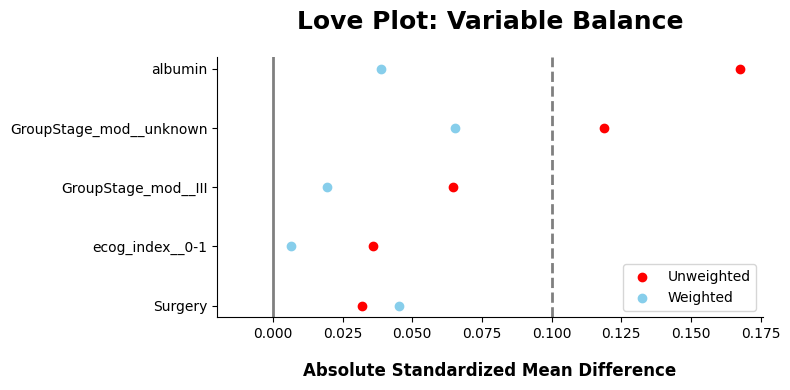

In [85]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 0.4 * len(smd_results_df) + 2))
            
# Plot points
ax.scatter(smd_results_df['smd_unweighted'], smd_results_df['variable'], label = 'Unweighted', color = 'red')
ax.scatter(smd_results_df['smd_weighted'], smd_results_df['variable'], label = 'Weighted', color = 'skyblue')

# Reference lines
ax.axvline(x = 0, color = 'black', linestyle = '-', linewidth = 2, alpha = 0.5) 
ax.axvline(x = 0.1, color = 'black', linestyle = '--', linewidth = 2, alpha = 0.5) 

# Axis labels and limits
ax.set_xlabel('Absolute Standardized Mean Difference', labelpad = 15, size = 12, weight = 'bold')
ax.set_xlim(-0.02)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Title legend
ax.set_title('Love Plot: Variable Balance', pad = 20, size = 18, weight = 'bold')
ax.legend(prop = {'size': 10})

plt.tight_layout()